In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
from rubin_scheduler.scheduler.utils import SkyAreaGenerator
%matplotlib inline

/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set the path to the baseline database
opsdb = '/home/idies/workspace/Storage/LiGuodong/persistent/LSST_NQSO/Baseline_4_0/Baseline/baseline_v4.0_10yrs.db'

# Extract the simulation name from the database file name by removing the '.db' extension
opsim = os.path.basename(opsdb).replace('.db', '')

# Set the resolution for the HEALPix grid (nside = 64)
nside = 64

# Generate sky area maps for the given resolution (nside)
survey_areas = SkyAreaGenerator(nside=nside)

# Return the footprint maps and their corresponding labels (e.g., LMC_SMC, bulge, etc.)
map_footprints, map_labels = survey_areas.return_maps()

# Select HEALPix IDs corresponding to specific regions in the sky
# Regions include: ['LMC_SMC', 'bulge', 'dusty_plane', '', 'lowdust', 'nes', 'scp', 'virgo']
maps = np.where(
    (map_labels == 'LMC_SMC') |          # Large Magellanic Cloud and Small Magellanic Cloud
    (map_labels == 'bulge') |            # Galactic bulge
    (map_labels == 'dusty_plane') |     # Dusty region of the plane
    (map_labels == '') |                # Empty region label (unspecified area)
    (map_labels == 'lowdust') |         # Low dust regions
    (map_labels == 'nes') |             # North Ecliptic Spur
    (map_labels == 'scp') |             # South Celestial Pole
    (map_labels == 'virgo')             # Virgo cluster
)[0]

# Create a metric to count the number of observations (visits) that occurred
count_metric = maf.CountMetric(col='observationStartMJD', metric_name='NVisits')

# Create a slicer for the selected HEALPix regions
slicer = maf.HealpixSubsetSlicer(nside=nside, hpid=maps)

# Define the constraint (None in this case, meaning no additional filtering)
constraint = None

# Create a MetricBundle for the 'nvisits' metric using the slicer and count metric
bundle = maf.MetricBundle(count_metric, slicer, constraint, run_name=opsim)

# Set the output directory where the results will be stored
outDir = './Nvisit/'

# Create a MetricBundleGroup to run the analysis and store the results
g = maf.MetricBundleGroup({'nvisits': bundle}, opsdb, out_dir=outDir)

# Run the MetricBundleGroup, which will execute the metric and store the results
g.run_all()


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


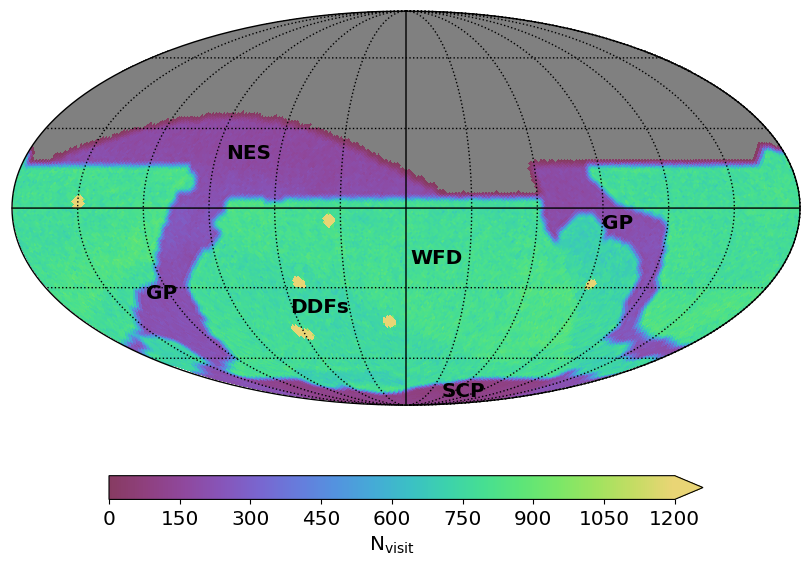

In [4]:
figformat = 'png'
ph = maf.PlotHandler(savefig=False, fig_format=figformat, thumbnail=False, dpi=270)
ph.set_metric_bundles([bundle])
ph.plot(plot_func=maf.plots.HealpixSkyMap(), plot_dicts={'color_min': 0, 'color_max':1200, 'figsize': (8, 7),
                   'labelsize': 'x-large', 'fontsize':'x-large', 'xlabel': r"$\rm N_{visit}$", 
                    'extend': 'max', 'title': '', 'colorbar_location':'top'})
plt.figtext(0.51, 0.45, 'WFD', fontsize='x-large', fontweight='bold', color='black')
plt.figtext(0.28, 0.6, 'NES', fontsize='x-large', fontweight='bold', color='black')
plt.figtext(0.18, 0.4, 'GP', fontsize='x-large', fontweight='bold', color='black')
plt.figtext(0.75, 0.5, 'GP', fontsize='x-large', fontweight='bold', color='black')
plt.figtext(0.55, 0.26, 'SCP', fontsize='x-large', fontweight='bold', color='black')
plt.figtext(0.36, 0.38, 'DDFs', fontsize='x-large', fontweight='bold', color='black')
plt.savefig('Figure1.png', facecolor='w', edgecolor='w', bbox_inches='tight',dpi=270)